In [1]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 
#from shapely.geometry import Point
#import geopandas as gpd
#from geopandas import GeoDataFrame
#import xarray as xr
#import netCDF4 as nc
#from netCDF4 import Dataset
#import xlrd
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        new_columns.append(pd.to_datetime(col).date())
    return new_columns

## 1- Extract daily Temp at each bgr station

In [ ]:
# idx corresponding to the indicies of long/lat in each nc file
temp_df = pd.read_csv("dataset/meta_data/bgr_location.csv")
print(temp_df.shape)
temp_df.head()

In [ ]:
# paths to all nc files 215 files each for a month from 1995 to 2012
from os import walk
folder_path =  "dataset/temperature/data/"
files= []
for (dirpath, dirnames, filenames) in walk(folder_path):
    files.extend(filenames)
    break
files[:2]

In [ ]:
# extract temps in each day of each nc file at the corresponding lat/longfor all months
for file_name in files:
    file_path = folder_path + file_name
    nc = netcdf.NetCDFFile(file_path,'r')
    days = nc.variables["datum"][:]
    for d, day in enumerate(days):
        #if day in unique_dates:
        temp_df[str(day)[:-4]] = nc.variables["temperature"][d,:,:].flatten()[temp_df["idx"]]
temp_df = temp_df[temp_df.columns] # to avoind Big/little endian issue
temp_df.head()

In [ ]:
# check the number of days in which the temps were measured
print(len(temp_df.columns[4:]))
print((pd.to_datetime("12.01.2012").date() - pd.to_datetime("01.01.1995").date()).days)

In [ ]:
# convert str date to datetime in the col name
columns =temp_df.columns
new_columns =list(temp_df.columns[:4])
print(columns[:6])
print(new_columns)
for day in columns[4:]:
    d = str(day)#[:-4]
    d = d[:4]+'-'+d[4:6]+"-"+d[6:]
    #print(d)
    d = datetime.fromisoformat(d).date()
    new_columns.append(d)
    #print(d)

temp_df.columns=new_columns 
temp_df.head()

In [ ]:
# drop irrelevant columns
temp_df = temp_df.drop(labels =["bgr_long","bgr_lat", "idx"], axis =1).set_index("proj_id")
temp_df.head()

In [ ]:
# reorder the columns by dates
temp_df = temp_df[sorted(temp_df.columns)]
print(temp_df.shape)
temp_df.head()

# Temp were measured between 01.01.1995 and 01.12.2012 6544 days (Dec  2012 not included) for 13492 bgr staion

In [ ]:
freq_level =  pd.read_csv("dataset/time_series/freq_level.csv").set_index("proj_id")
print(freq_level.shape)
freq_level.head()

### 12590 bgr stations (out of 13492) have ground_water t s, -> we drop the rest from the temp_df

In [ ]:
# keep the inntersection between freq_level and the daily_temp
temp_freq_df = pd.concat([freq_level, temp_df], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(temp_freq_df.shape)
temp_freq_df.head()

In [ ]:
freq_level = temp_freq_df.drop(temp_freq_df.columns[5:], axis =1)
daily_temp = temp_freq_df.drop(temp_freq_df.columns[:5], axis =1)
print("freq_level: ",freq_level.shape)
print("daily_temp: ",daily_temp.shape)

## in total, there are 12382 t s with their corrsponding temp

In [ ]:
# plot some samples of daily temp
t_s_dates = daily_temp.iloc[6666][2000:2500].index #sassumingly here to filter the temp points
plt.figure(figsize=(20,10))
daily_temp.loc["BB_25470023"][t_s_dates].plot(color='blue',grid=True)
#temp_df.iloc[0][t_s_dates].plot(color='red',grid=True, secondary_y=True)
daily_temp.iloc[5000][t_s_dates].plot(color='black',grid=True, secondary_y=True)
plt.title("the temp t s (500 point for zoom)")

In [ ]:
sum((temp_df.iloc[9845] -temp_df.iloc[1025])<0.05)

In [ ]:
# save the daily temps, and the filter_freq_levels
#daily_temp.to_csv("dataset/temperature/daily_temp.csv")#, index =0)
#freq_level.to_csv("dataset/temperature/filtered_freq_level.csv")

## 2- Compute the ave temp according to the t s freq

###     computation criteria: 
###         daily_freq   :             ave t s freq <2 days,     ave temp = daily ....... 3037 t s total
###         mid-weekly:  2 <=   ave t s freq < 5 days,     ave temp = every 4 days...  965 t s total
###         weekly        :  5 <=   ave t s freq  < 10 days,       ave temp = 7 days......  5742 t s total
###         fortnight     :  10 <= ave t s freq <= 20 days,     ave temp  = 14 days.... 1667 t s total
###         low freq       : 20 <   ave t s freq days,      ave temp = 30 days..... 971 t s total

In [3]:
# import daily_temp (ave computed in place)
ave_temp = pd.read_csv("dataset/temperature/daily_temp.csv").set_index("proj_id")
ave_temp.columns= convert_col_to_date(ave_temp.columns)
print(ave_temp.shape)
ave_temp.head()

(12382, 6544)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25470024,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25480025,17,-6,-27,-67,-63,-80,-74,-52,-19,18,...,44,58,33,49,60,61,64,48,42,19
BB_25480026,14,-8,-28,-65,-65,-81,-77,-56,-20,16,...,46,59,36,49,62,63,65,49,38,15
BB_25481088,17,-6,-26,-66,-62,-80,-74,-52,-19,18,...,44,59,33,49,60,62,64,48,42,19


In [4]:
# import daily_temp
freq_level = pd.read_csv("dataset/temperature/filtered_freq_level.csv").set_index("proj_id")
print(freq_level.shape)
freq_level.head()

(12382, 5)


,daily,mid_weekly,weekly,fortnight,low_freq
proj_id,,,,,
BB_25470023,False,False,True,False,False
BB_25470024,False,False,True,False,False
BB_25480025,False,False,True,False,False
BB_25480026,False,False,True,False,False
BB_25481088,True,False,False,False,False


In [5]:
print(freq_level[freq_level["daily"]].shape)
print(freq_level[freq_level["mid_weekly"]].shape)
print(freq_level[freq_level["weekly"]].shape)
print(freq_level[freq_level["fortnight"]].shape)
print(freq_level[freq_level["low_freq"]].shape)

(3037, 5)
(965, 5)
(5742, 5)
(1667, 5)
(971, 5)


In [6]:
# add a column for freq in the daily_temp
def add_freq(bgr):
    #1. get the t s name
    #2. determine freq
    #3. compute ave
    #bgr = ave_temp.index[7569]
    freq = 0
    if freq_level.loc[bgr]["daily"]:
        #print("daily")
        freq = 1
    if freq_level.loc[bgr]["mid_weekly"]:
        #print("mid_weekly")
        freq = 4
    if freq_level.loc[bgr]["weekly"]:
        #print("weekly")
        freq = 7
    if freq_level.loc[bgr]["fortnight"]:
        #print("fortnight")
        freq = 14
    if freq_level.loc[bgr]["low_freq"]:
        #print("low_freq")
        freq = 30
    return freq


In [7]:
ave_temp = ave_temp.reset_index()
ave_temp["freq"] = ave_temp["proj_id"].apply(lambda row:add_freq(row))#, axis=1)
ave_temp = ave_temp.set_index("proj_id")
print(ave_temp.shape)
ave_temp.head()

(12382, 6545)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,59,35,48,62,63,65,49,39,15,7
BB_25470024,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,59,35,48,62,63,65,49,39,15,7
BB_25480025,17,-6,-27,-67,-63,-80,-74,-52,-19,18,...,58,33,49,60,61,64,48,42,19,7
BB_25480026,14,-8,-28,-65,-65,-81,-77,-56,-20,16,...,59,36,49,62,63,65,49,38,15,7
BB_25481088,17,-6,-26,-66,-62,-80,-74,-52,-19,18,...,59,33,49,60,62,64,48,42,19,1


In [8]:
# compute the ave_temp 
T1 = datetime.now()
print(T1)
def compute_ave_temp(row):
    freq = row[-1]
    result = list(row.values[:freq-1])
    result.extend([round(row[i-freq:i].mean(),4) for i in range(freq,len(row))])
    result.append(freq)
    #result = pd.Series(result)
    return pd.Series(result)

ave_temp = ave_temp.apply(lambda row:compute_ave_temp(row), axis=1)
T2 =datetime.now()
print(T2)
print(T2-T1)
print(ave_temp.shape)
ave_temp.head()

2020-12-16 04:13:31.367664
2020-12-16 06:10:08.575970
1:56:37.208306
(12382, 6545)


,0,1,2,3,4,5,6,7,8,9,...,6535,6536,6537,6538,6539,6540,6541,6542,6543,6544
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,14.0,-8.0,-26.0,-63.0,-65.0,-80.0,-43.4286,-53.4286,-55.0000,-49.0000,...,33.7143,39.2857,43.4286,47.2857,51.5714,54.0000,54.4286,51.5714,48.7143,7.0
BB_25470024,14.0,-8.0,-26.0,-63.0,-65.0,-80.0,-43.4286,-53.4286,-55.0000,-49.0000,...,33.7143,39.2857,43.4286,47.2857,51.5714,54.0000,54.4286,51.5714,48.7143,7.0
BB_25480025,17.0,-6.0,-27.0,-67.0,-63.0,-80.0,-42.8571,-52.7143,-54.5714,-48.1429,...,32.4286,37.8571,42.4286,46.1429,50.1429,52.7143,53.2857,51.0000,49.0000,7.0
BB_25480026,14.0,-8.0,-28.0,-65.0,-65.0,-81.0,-44.2857,-54.2857,-56.0000,-49.7143,...,33.8571,39.4286,43.5714,47.4286,51.8571,54.2857,54.7143,51.7143,48.7143,7.0
BB_25481088,17.0,-6.0,-26.0,-66.0,-62.0,-80.0,-74.0000,-52.0000,-19.0000,18.0000,...,59.0000,33.0000,49.0000,60.0000,62.0000,64.0000,48.0000,42.0000,19.0000,1.0


In [ ]:
# rename ave temp columns
col = list(daily_temp.columns)
col.append("freq")
ave_temp.columns = col

In [66]:
# save the daily temps, and the filter_freq_levels
#ave_temp.to_csv("dataset/temperature/ave_temp.csv")#, index =0)


In [16]:
# import daily_temp (ave computed in place)
daily_temp = pd.read_csv("dataset/temperature/daily_temp.csv").set_index("proj_id")
daily_temp.columns= convert_col_to_date(daily_temp.columns)
print(daily_temp.shape)
daily_temp.head()

(12382, 6544)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25470024,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25480025,17,-6,-27,-67,-63,-80,-74,-52,-19,18,...,44,58,33,49,60,61,64,48,42,19
BB_25480026,14,-8,-28,-65,-65,-81,-77,-56,-20,16,...,46,59,36,49,62,63,65,49,38,15
BB_25481088,17,-6,-26,-66,-62,-80,-74,-52,-19,18,...,44,59,33,49,60,62,64,48,42,19


In [ ]:
# import daily_temp (ave computed in place)
ave_temp = pd.read_csv("dataset/temperature/ave_temp.csv").set_index("proj_id")
columns = convert_col_to_date(ave_temp.columns[:-1])
columns.append("freq")
ave_temp.columns= columns
print(ave_temp.shape)
ave_temp.head()


In [81]:
# import t s and convert into date type
grouped_t_s = pd.read_csv("dataset/time_series/grouped_t_s.csv")
grouped_t_s = grouped_t_s.set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
grouped_t_s.head()

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28,37.32,37.33,37.35,37.33,37.35,37.3,37.31,37.34,37.34


In [133]:
#bgr_serial = 1246 #freq 1
#bgr_serial =  #freq 
bgr_serial = 2146 #freq 7
#bgr_serial = 2461 #freq 7
#bgr_serial = 4689 #freq 14
#bgr_serial = 8888 #freq 30
f =ave_temp.iloc[bgr_serial][-1] 
ts_index = grouped_t_s.iloc[bgr_serial].dropna().index
# temp rows are not measured after 30.11.2012, -> here we match t s and temp dates 
# i.e exclude the last month of the ts 
ts_index = ts_index[ts_index < ave_temp.iloc[bgr_serial].index[-2]]

Text(0.5, 1.0, 'daily_temp')

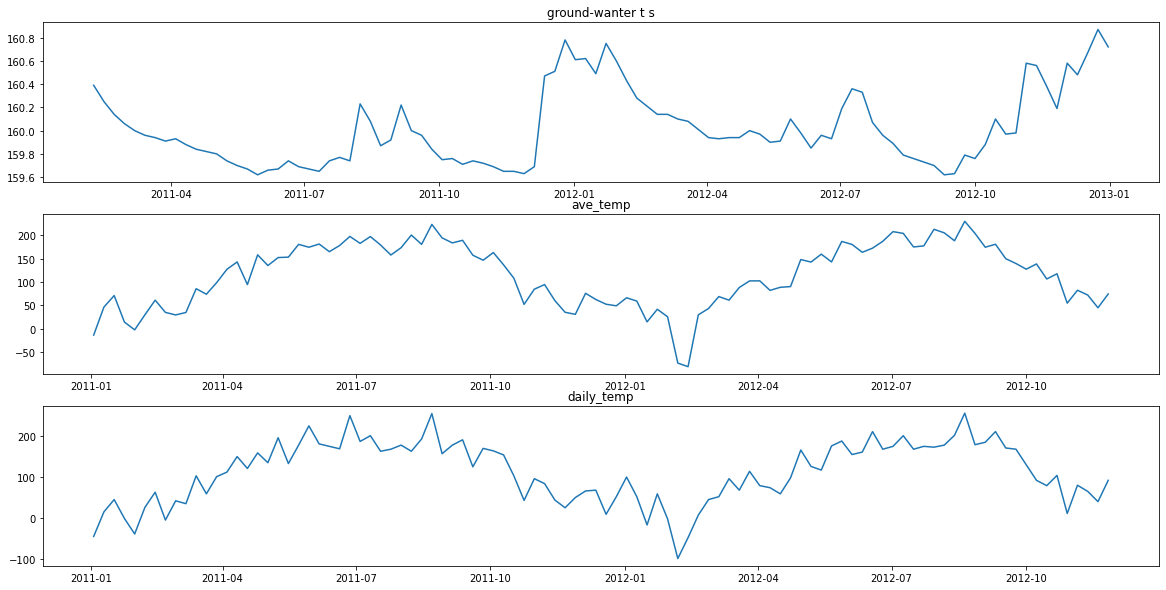

In [137]:
fig.suptitle('Vertically stacked subplots')

fig, axs = plt.subplots(3,1, figsize=(20,10))
axs[0].plot(grouped_t_s.iloc[bgr_serial].dropna()[-100:])
axs[0].set_title('ground-wanter t s')
axs[1].plot(ave_temp.iloc[bgr_serial].dropna()[ts_index][-100:])
axs[1].set_title('ave_temp')
axs[2].plot(daily_temp.iloc[bgr_serial].dropna()[ts_index][-100:])
axs[2].set_title('daily_temp')


Text(0.5, 1.0, 'daily_temp (red) vs ave_temp (blue) at a bgr station, freq=7.0')

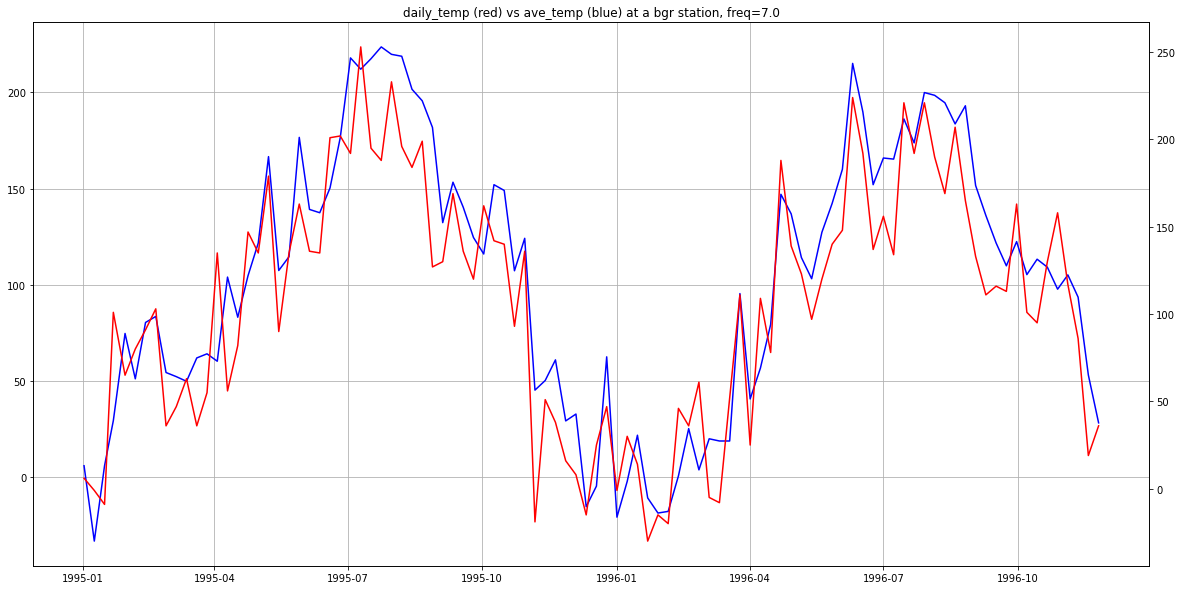

In [140]:
plt.figure(figsize=(20,10))

ave_temp.iloc[bgr_serial].dropna()[ts_index][:100].plot(color='blue',grid=True)
daily_temp.iloc[bgr_serial].dropna()[ts_index][:100].plot(color='red',grid=True, secondary_y=True)
#ave_temp.loc["BB_25481088"].dropna()[5000:5200].plot(color='red',grid=True, secondary_y=True)
plt.title(f"daily_temp (red) vs ave_temp (blue) at a bgr station, freq={f}")